# A Tutorial on Current Segregation Procedure

ACT uses the segreagation approach introduced in [Alturki et al., (2016)](https://www.sciencedirect.com/science/article/pii/S0306452216303797). The main idea of the approach is that cell currents can be isolated into distinct functional modules along the voltage axis based on their activation functions. This notebook gives a tutorial on general principles of segregation.

## Segregation approach

1. Separate currents into functional modules. As a guideline, the following separating can be used:
   - Passive: h
   - Spiking: NaT, Kdr
   - Bursting / adaptation: KA, CaT, CaS

2. Plot activation (m-) functions for active channels and deactivation function for the h channel. Choose a probability threshold (as a guideline, we use 0.16, corresponding to 1 standard deviation of the normal curve) and determine corresponding voltage values for each current. The threshold for the module is set as the minimum of its currents' thresholds.

3. To smoothen the transition to 0, linearly extrapolate each activation function in a segment betwenn the cutoff voltage and +2-3 mV to the right (as a guideline, we use 2 mV).
   
4. Simulate the segregated cell and compare the output to the original. To mitigate discrepancies, one can slightly adjust membrance capacitance or conductances of passive or active channels.

## Examples

In [1]:
from act.cell_model import ACTCellModel
from act.simulator import ACTSimulator
from act.segregation import ACTSegregator
from act.act_types import SimulationParameters, CurrentInjection, PassiveProperties

import matplotlib.pyplot as plt
import numpy as np

### Spiker

Classic Hodgking-Huxely-based Spiker model.

Parameters (both original and segregated):
- Cm = 1
- gnabar = .12 (S/cm2)
- gkbar = .036 (S/cm2)
- gl = .0003 (S/cm2)
- el = -54.3 (mV)

Modules:
- Spiking: [gnabar, gkbar], (-77.017; +inf)

**Step 1.** The spiker model has only 2 modules: 
- Passive (includes only the leak channel, so no action needed).
- Spiking (Na and Kdr channels).

**Steps 2 and 3.** Transfer the activation functions from the modfiles and plot them. We additionally plot E-leak for reference.

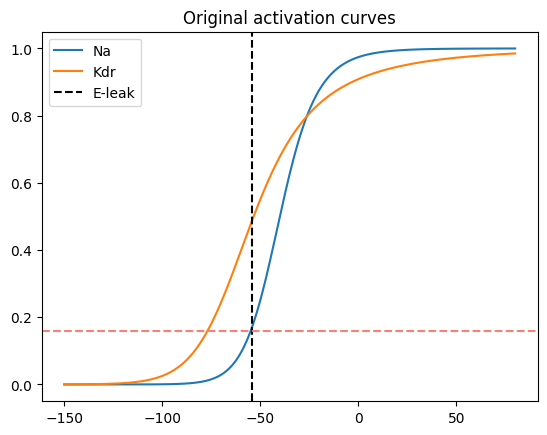

In [2]:
# From ACT/data/Spiker/orig/modfiles/hh.mod
def vtrap(x,y):
    if np.any(np.abs(x/y) < 1e-6):
        vtrap = y * (1 - x/y/2)
    else:
        vtrap = x / (np.exp(x/y) - 1)
    return vtrap

def Na(v):
    aNa = 0.1 * vtrap(-(v + 40), 10)
    bNa =  4 * np.exp(-(v + 65) / 18)
    return aNa / (aNa + bNa)

def Kdr(v):
    aK = 0.01 * vtrap(-(v + 55),10) 
    bK = 0.125 * np.exp(-(v + 65) / 80)
    return aK / (aK + bK)

v = np.linspace(-150, 80, 1000)

plt.plot(v, Na(v), label = 'Na')
plt.plot(v, Kdr(v), label = 'Kdr')
plt.title("Original activation curves")
plt.axvline(-54.3, color = 'black', ls = '--', label = "E-leak")
plt.axhline(0.16, color = 'salmon', ls = '--')
plt.legend()

The segregation procedure above is implemented in `ACTSegregator`. It outputs segregated activation functions together with text to update the modfiles (the text includes cutoff and extrapolation voltages and line parameters).

In [3]:
segregator = ACTSegregator()
seg_Na, seg_Kdr = segregator.segregate(v, [Na(v), Kdr(v)])

Update the modfiles with the following:
----------
Activation curve 0:

        :Segregation
        if (v < -75.017) {
        replace_with_var_name = 0.008 * v + 0.58
        }
        if (v < -77.017) {
        replace_with_var_name = 0
        }
        
----------
Activation curve 1:

        :Segregation
        if (v < -75.017) {
        replace_with_var_name = 0.089 * v + 6.892
        }
        if (v < -77.017) {
        replace_with_var_name = 0
        }
        


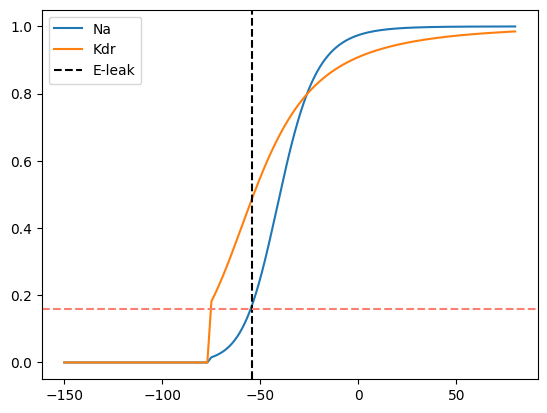

In [ ]:
plt.plot(v, seg_Na, label = 'Na')
plt.plot(v, seg_Kdr, label = 'Kdr')
plt.title("Segregated activation curves")
plt.axvline(-54.3, color = 'black', ls = '--', label = "E-leak")
plt.axhline(0.16, color = 'salmon', ls = '--')
plt.legend()

**Step 4.** Make a copy of the original folder with simulation templates and modfiles and name it `seg`. Update the modfile with the segregator's output. Now we simulate the original and segregated cells.

In [5]:
orig_cell = ACTCellModel(
    path_to_hoc_file = "/Users/vladimiromelyusik/ACT/data/Spiker/orig/template.hoc",
    path_to_modfiles = "/Users/vladimiromelyusik/ACT/data/Spiker/orig/modfiles",
    active_channels = ["hh_spiker.gnabar", "hh_spiker.gkbar"],
    passive_properties = PassiveProperties(g_leak = "gl"),
    cell_name = "Spiker"
)

simulator = ACTSimulator(output_folder_name = "output")
simulator.submit_job(orig_cell, SimulationParameters(sim_name = "spiker_orig", sim_idx = 1, h_celsius = 6.3, CI = CurrentInjection(type = "constant", amp = 0.1)))
simulator.run_jobs(1)


        ACTSimulator (2024)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


In [6]:
seg_cell = ACTCellModel(
    path_to_hoc_file = "/Users/vladimiromelyusik/ACT/data/Spiker/seg/template.hoc",
    path_to_modfiles = "/Users/vladimiromelyusik/ACT/data/Spiker/seg/modfiles",
    active_channels = ["hh_spiker.gnabar", "hh_spiker.gkbar"],
    passive_properties = PassiveProperties(g_leak = "gl"),
    cell_name = "Spiker"
)

simulator.submit_job(seg_cell, SimulationParameters(sim_name = "spiker_seg", sim_idx = 2, h_celsius = 6.3, CI = CurrentInjection(type = "constant", amp = 0.1)))
simulator.run_jobs(1)

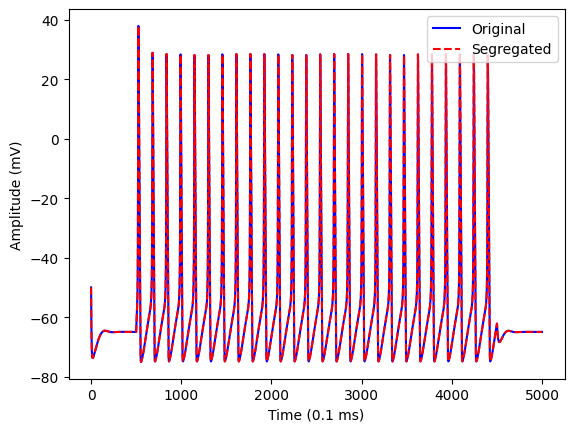

In [11]:
orig_out = np.load("output/spiker_orig/out_1.npy")
seg_out = np.load("output/spiker_seg/out_2.npy")

plt.plot(orig_out[:, 0], label = "Original", c = 'blue')
plt.plot(seg_out[:, 0], label = "Segregated", ls = '--', c = 'red')
plt.ylabel("Amplitude (mV)")
plt.xlabel("Time (0.1 ms)")
plt.legend()

### BursterCa

Ca-based burster.

Parameters (original / segregated where changed):
- eleak = -50
- gbar_leak = 4e-05
- gbar_na = 0.13 / 0.12
- gbar_kdr = 0.1 / 0.2
- gbar_cas = 0.01
- gbar_ka = 0.17 / 0.11
- gbar_cat = 0.005

Modules:
- Bursting: [gbar_cas, gbar_ka, gbar_cat], (-46.627; +inf)
- Spiking: [gnabar, gkbar], (-34.424; +inf)

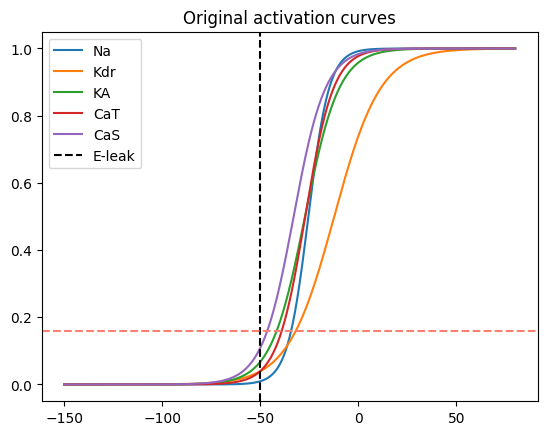

In [6]:
def Na(v):
    return 1.0/(1.0+ (np.exp((v+25.5)/(-5.29))))

def Kdr(v):
    return 1.0/(1.0 + (np.exp((v+12.3)/(-11.8))))

def KA(v):
    return 1.0/(1.0+(np.exp((v+27.2)/(-8.7))))

def CaT(v):
    return 1.0/(1.0+ (np.exp((v+27.1)/(-7.2))))

def CaS(v):
    return (1.0)/(1+ (np.exp((v+33.0)/(-8.1)))) 

v = np.linspace(-150, 80, 1000)

for func, func_name in zip([Na, Kdr, KA, CaT, CaS], ["Na", "Kdr", "KA", "CaT", "CaS"]):
    plt.plot(v, func(v), label = func_name)

plt.title("Original activation curves")
plt.axvline(-50, color = 'black', ls = '--', label = "E-leak")
plt.axhline(0.16, color = 'salmon', ls = '--')
plt.legend()

In [7]:
segregator = ACTSegregator()
segregated_spiking = segregator.segregate(v, [Na(v), Kdr(v)])

Update the modfiles with the following:
----------
Activation curve 0:

        :Segregation
        if (v < -32.424) {
        replace_with_var_name = 0.104 * v + 3.575
        }
        if (v < -34.424) {
        replace_with_var_name = 0
        }
        
----------
Activation curve 1:

        :Segregation
        if (v < -32.424) {
        replace_with_var_name = 0.076 * v + 2.617
        }
        if (v < -34.424) {
        replace_with_var_name = 0
        }
        


In [8]:
segregated_bursting = segregator.segregate(v, [KA(v), CaT(v), CaS(v)])

Update the modfiles with the following:
----------
Activation curve 0:

        :Segregation
        if (v < -44.627) {
        replace_with_var_name = 0.058 * v + 2.727
        }
        if (v < -46.627) {
        replace_with_var_name = 0
        }
        
----------
Activation curve 1:

        :Segregation
        if (v < -44.627) {
        replace_with_var_name = 0.039 * v + 1.841
        }
        if (v < -46.627) {
        replace_with_var_name = 0
        }
        
----------
Activation curve 2:

        :Segregation
        if (v < -44.627) {
        replace_with_var_name = 0.095 * v + 4.412
        }
        if (v < -46.627) {
        replace_with_var_name = 0
        }
        


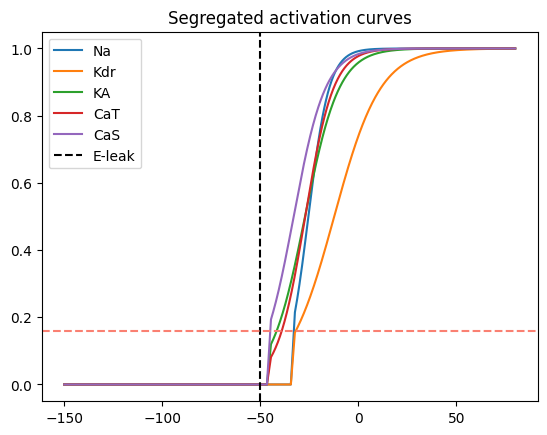

In [9]:
for ac, ac_name in zip(segregated_spiking, ["Na", "Kdr"]):
    plt.plot(v, ac, label = ac_name)
for ac, ac_name in zip(segregated_bursting, ["KA", "CaT", "CaS"]):
    plt.plot(v, ac, label = ac_name)

plt.title("Segregated activation curves")
plt.axvline(-50, color = 'black', ls = '--', label = "E-leak")
plt.axhline(0.16, color = 'salmon', ls = '--')
plt.legend()

In [22]:
orig_cell = ACTCellModel(
    path_to_hoc_file = "/Users/vladimiromelyusik/ACT/data/BursterCa/orig/template.hoc",
    path_to_modfiles = "/Users/vladimiromelyusik/ACT/data/BursterCa/orig/modfiles",
    active_channels = ["gbar_na", "gbar_kdr", "gbar_ka", "gbar_cat", "gbar_cas"],
    passive_properties = PassiveProperties(g_leak = "gbar_leak"),
    cell_name = "BursterCa"
)

simulator = ACTSimulator(output_folder_name = "output")
simulator.submit_job(orig_cell, SimulationParameters(sim_name = "burster_orig", sim_idx = 1, h_celsius = 37, CI = CurrentInjection(type = "constant", amp = 0.1)))
simulator.run_jobs(1)


        ACTSimulator (2024)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


In [63]:
seg_cell = ACTCellModel(
    path_to_hoc_file = "/Users/vladimiromelyusik/ACT/data/BursterCa/seg/template.hoc",
    path_to_modfiles = "/Users/vladimiromelyusik/ACT/data/BursterCa/seg/modfiles",
    active_channels = ["gbar_na", "gbar_kdr", "gbar_ka", "gbar_cat", "gbar_cas"],
    passive_properties = PassiveProperties(g_leak = "gbar_leak"),
    cell_name = "BursterCa"
)

simulator = ACTSimulator(output_folder_name = "output")
simulator.submit_job(seg_cell, SimulationParameters(sim_name = "burster_seg", sim_idx = 1, h_celsius = 37, CI = CurrentInjection(type = "constant", amp = 0.1)))
simulator.run_jobs(1)


        ACTSimulator (2024)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


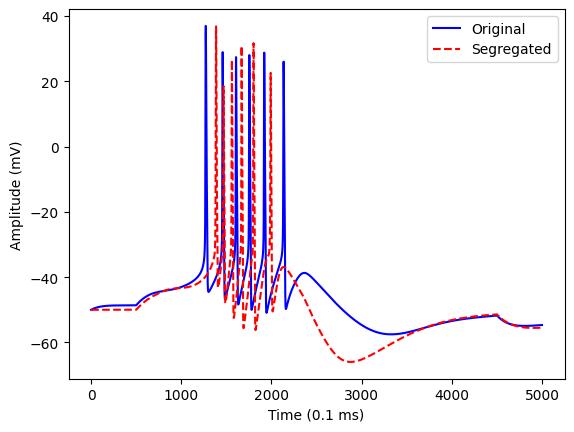

In [64]:
orig_out = np.load("output/burster_orig/out_1.npy")
seg_out = np.load("output/burster_seg/out_1.npy")

plt.plot(orig_out[:, 0], label = "Original", c = 'blue')
plt.plot(seg_out[:, 0], label = "Segregated", ls = '--', c = 'red')
plt.ylabel("Amplitude (mV)")
plt.xlabel("Time (0.1 ms)")
plt.legend()